In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import sys
import os
import torch
from statsmodels.tsa.stattools import adfuller

In [49]:
ENERGY_PATH = "data/energy/"
WEATHER_PATH = "data/weather/Weather_Data_Germany.csv"

weather_data = pd.read_csv(WEATHER_PATH, sep=",")
prices_data = pd.read_csv(ENERGY_PATH + "Prices_Europe.csv", sep=";")
installed_capacity = pd.read_csv(ENERGY_PATH + "Installed_Capacity_Germany.csv", sep=";")
demand_data = pd.read_csv(ENERGY_PATH + "Reaslised_Demand_Germany.csv", sep=";")
supply_data = pd.read_csv(ENERGY_PATH + "Realised_Supply_Germany.csv", sep=";")


In [50]:

date_range_from = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:45', freq='15min')
date_range_to = pd.date_range(start='2019-01-01 00:15', end='2023-01-01 00:00', freq='15min')
date_range_from_prices = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:00', freq='1H')
date_range_to_prices = pd.date_range(start='2019-01-01 01:00', end='2023-01-01 00:00', freq='1H')

In [51]:
demand_data['Date from'] = date_range_from
demand_data['Date to'] = date_range_to
supply_data['Date from'] = date_range_from
supply_data['Date to'] = date_range_to
prices_data['Date from'] = date_range_from_prices
prices_data['Date to'] = date_range_to_prices
demand_data['Date from'] = pd.to_datetime(demand_data['Date from'],format='%d.%m.%y %H:%M')
demand_data['Date to'] = pd.to_datetime(demand_data['Date to'], format='%d.%m.%y %H:%M')
supply_data['Date from'] = pd.to_datetime(supply_data['Date from'], format='%d.%m.%y %H:%M')
supply_data['Date to'] = pd.to_datetime(supply_data['Date to'], format='%d.%m.%y %H:%M')
prices_data['Date from'] = pd.to_datetime(prices_data['Date from'],format='%d.%m.%y %H:%M')
prices_data['Date to'] = pd.to_datetime(prices_data['Date to'],format='%d.%m.%y %H:%M')
installed_capacity['Date from'] = pd.to_datetime(installed_capacity['Date from'])
installed_capacity['Date to'] = pd.to_datetime(installed_capacity['Date to'])
weather_data['forecast_origin'] = pd.to_datetime(weather_data['forecast_origin'])
weather_data['time'] = pd.to_datetime(weather_data['time'])

In [52]:
def clean_convert_to_float(x): #there is probably a better way to do this
    if not isinstance(x, str):
        return x
    x = x.replace('.', '').replace(',', '.')
    try:
        return float(x)
    except ValueError:
        return x
    

In [53]:
demand_data.iloc[:, 2:] = demand_data.iloc[:, 2:].applymap(clean_convert_to_float)

supply_data.rename(columns={'Wind Offshore [MW] ': 'Wind Offshore [MW]'}, inplace=True)
supply_data.iloc[:, 2:] = supply_data.iloc[:, 2:].applymap(clean_convert_to_float)
supply_data["Wind total [MW]"] = supply_data[["Wind Offshore [MW]","Wind Onshore [MW]"]].sum( axis=1)

installed_capacity.iloc[:, 2:] = installed_capacity.iloc[:, 2:].applymap(clean_convert_to_float)
installed_capacity["Wind total [MW]"] = installed_capacity[["Wind Offshore [MW] ", "Wind Onshore [MW]"]].sum(axis=1)


prices_data.replace('-', np.nan, inplace=True)
prices_data.iloc[:, 2:] = prices_data.iloc[:, 2:].applymap(clean_convert_to_float)

In [54]:
#for weather, average the values for weather station. 
#There might be a way to include the location of the weather station in the model
average_weather =  weather_data.groupby('time').mean().reset_index()

average_weather.drop(columns=['longitude', 'latitude', 'z'], inplace=True)
average_weather.head()

,time,cdir,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,2019-01-01 00:00:00,0.0,103009.967750,507.635043,0.966562,3.867164,1.065368,278.216013,0.0,0.0,0.0,0.000000,0.741971,6.545994,1.122055
1,2019-01-01 01:00:00,0.0,102964.489612,544.627164,0.959348,4.092345,1.116217,278.310794,0.0,0.0,0.0,0.000038,0.742205,6.838839,1.241379
2,2019-01-01 02:00:00,0.0,102908.208325,575.103757,0.966846,4.320050,1.223478,278.206292,0.0,0.0,0.0,0.000070,0.742254,7.183921,1.428783
3,2019-01-01 03:00:00,0.0,102827.034387,612.314609,0.979125,4.638074,1.222571,278.140331,0.0,0.0,0.0,0.000099,0.742272,7.660834,1.501984
4,2019-01-01 04:00:00,0.0,102725.913987,660.112603,0.981526,4.980449,1.055763,278.102989,0.0,0.0,0.0,0.000135,0.742255,8.147790,1.289936


In [55]:
#find columns with missing values
missing_demand = demand_data.isnull().sum()
missing_supply = supply_data.isnull().sum()
missing_weather = weather_data.isnull().sum()
missing_prices = prices_data.isnull().sum()
missing_capacity = installed_capacity.isnull().sum()
print("Missing values in demand data: \n", missing_demand[missing_demand > 0])
print("Missing values in supply data: \n", missing_supply[missing_supply > 0])
print("Missing values in weather data: \n", missing_weather[missing_weather > 0])
print("Missing values in prices data: \n", missing_prices[missing_prices > 0])
print("Missing values in capacity data: \n", missing_capacity[missing_capacity > 0])

Missing values in demand data: 
 Series([], dtype: int64)
Missing values in supply data: 
 Series([], dtype: int64)
Missing values in weather data: 
 Series([], dtype: int64)
Missing values in prices data: 
 ∅ Neighbouring DE/LU [€/MWh]     7776
Poland [€/MWh]                   7776
DE/AT/LU [€/MWh]                35064
Hungary [€/MWh]                    24
dtype: int64
Missing values in capacity data: 
 Series([], dtype: int64)


In [56]:
supply_data_hourly = supply_data.resample('1H', on='Date from').mean()
demand_data_hourly = demand_data.resample('1H', on='Date from').mean()


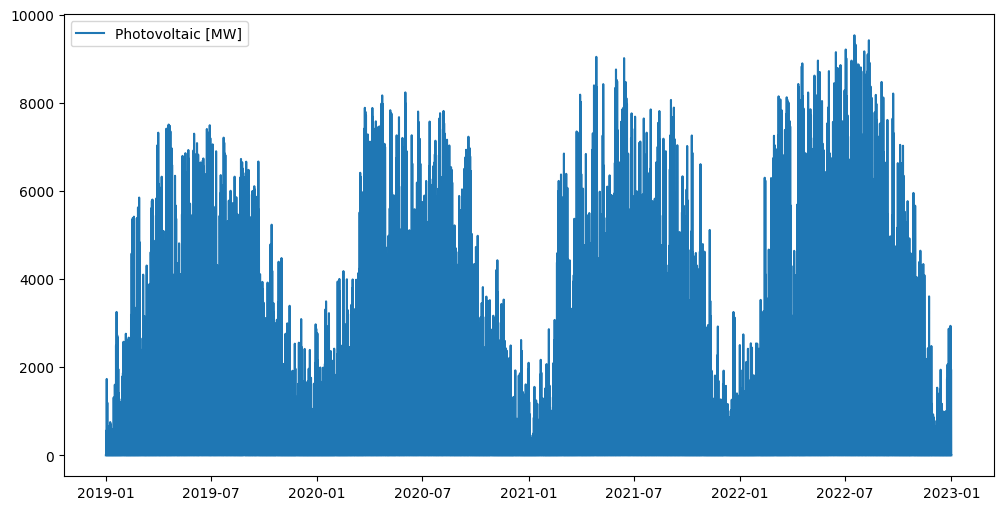

In [57]:
#plot supply data trained hourly
plt.figure(figsize=(12, 6))
plt.plot(supply_data_hourly.index, supply_data_hourly['Photovoltaic [MW]'], label='Photovoltaic [MW]')
plt.legend()
plt.show()

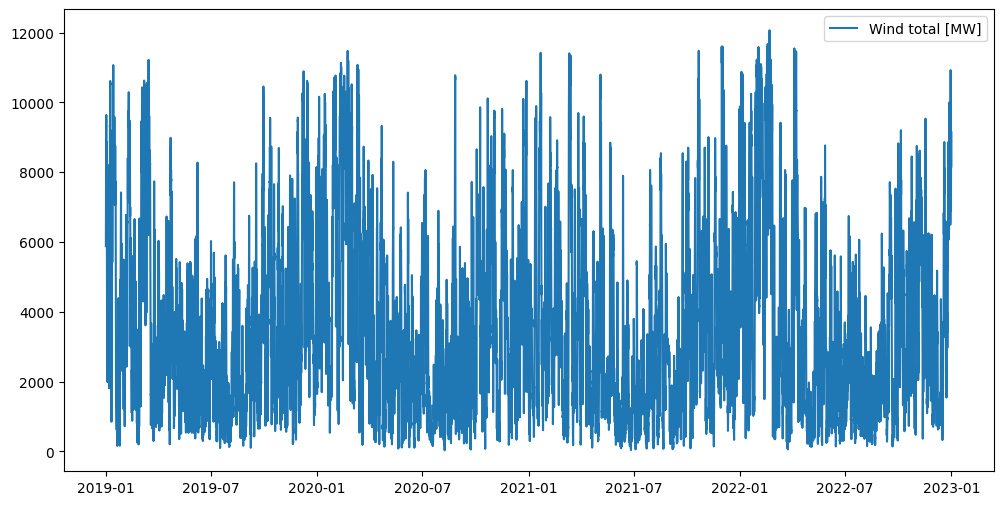

In [58]:
#plot supply data trained hourly
plt.figure(figsize=(12, 6))
plt.plot(supply_data_hourly.index, supply_data_hourly['Wind total [MW]'], label='Wind total [MW]')
plt.legend()
plt.show()

In [59]:
# Select only the columns we need and add more that we need
supply_data_hourly = supply_data_hourly[['Photovoltaic [MW]', 'Wind total [MW]']] 
installed_capacity = installed_capacity[['Date from', 'Date to', 'Wind total [MW]', 'Photovoltaic [MW]']]
installed_capacity['Year'] = installed_capacity['Date from'].dt.year
# rename Wind total and Photovoltaic columns
installed_capacity.rename(columns={'Wind total [MW]': 'Wind total [MW] installed', 'Photovoltaic [MW]': 'Photovoltaic [MW] installed'}, inplace=True)
installed_capacity = installed_capacity[['Wind total [MW] installed', 'Photovoltaic [MW] installed', 'Year']]
prices_data = prices_data[['Date from', 'Germany/Luxembourg [€/MWh]']]
supply_data_hourly.head()

,Photovoltaic [MW],Wind total [MW]
Date from,,
2019-01-01 00:00:00,0.0,5881.4375
2019-01-01 01:00:00,0.0,6308.4375
2019-01-01 02:00:00,0.0,6418.3750
2019-01-01 03:00:00,0.0,6797.5000
2019-01-01 04:00:00,0.0,7244.2500


In [60]:
demand_data_hourly.head()

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh]
Date from,,,
2019-01-01 00:00:00,10816.3750,4934.9375,343.750
2019-01-01 01:00:00,10413.5000,4105.0625,383.375
2019-01-01 02:00:00,10028.4375,3610.0625,649.625
2019-01-01 03:00:00,9828.2500,3030.7500,858.375
2019-01-01 04:00:00,9774.3125,2530.0625,956.500


In [61]:
installed_capacity.head()

,Wind total [MW] installed,Photovoltaic [MW] installed,Year
0,58787.0,44036.0,2019
1,61057.0,47754.0,2020
2,62119.0,50410.0,2021
3,63076.0,57744.0,2022


In [62]:
prices_data.head()

,Date from,Germany/Luxembourg [€/MWh]
0,2019-01-01 00:00:00,28.32
1,2019-01-01 01:00:00,10.07
2,2019-01-01 02:00:00,-4.08
3,2019-01-01 03:00:00,-9.91
4,2019-01-01 04:00:00,-7.41


In [63]:
#make Date the index for price and weather as well
prices_data.set_index('Date from', inplace=True)
average_weather.set_index('time', inplace=True)

In [64]:
average_weather.head()

,cdir,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
time,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,103009.967750,507.635043,0.966562,3.867164,1.065368,278.216013,0.0,0.0,0.0,0.000000,0.741971,6.545994,1.122055
2019-01-01 01:00:00,0.0,102964.489612,544.627164,0.959348,4.092345,1.116217,278.310794,0.0,0.0,0.0,0.000038,0.742205,6.838839,1.241379
2019-01-01 02:00:00,0.0,102908.208325,575.103757,0.966846,4.320050,1.223478,278.206292,0.0,0.0,0.0,0.000070,0.742254,7.183921,1.428783
2019-01-01 03:00:00,0.0,102827.034387,612.314609,0.979125,4.638074,1.222571,278.140331,0.0,0.0,0.0,0.000099,0.742272,7.660834,1.501984
2019-01-01 04:00:00,0.0,102725.913987,660.112603,0.981526,4.980449,1.055763,278.102989,0.0,0.0,0.0,0.000135,0.742255,8.147790,1.289936


In [65]:
# split data into train, val and test set
# train: 2019-2020
# val: 2021
# test: 2022
demand_data_train_hourly = demand_data_hourly.loc['2019':'2021']
supply_data_train_hourly = supply_data_hourly.loc['2019':'2021']
average_weather_train = average_weather
prices_data_train = prices_data.loc['2019':'2021']
installed_capacity_train = installed_capacity[installed_capacity['Year'] <= 2021]
assert len(demand_data_train_hourly) == len(supply_data_train_hourly) == len(average_weather_train) == len(prices_data_train)


In [66]:
# create big dataframe with all the data
dataset_train = pd.concat([demand_data_train_hourly, supply_data_train_hourly, average_weather_train, prices_data_train], axis=1)
# add date as a column
dataset_train['Date'] = dataset_train.index


In [67]:
dataset_train['Year'] = dataset_train['Date'].dt.year
dataset_train = dataset_train.merge(installed_capacity_train, on='Year', how='left')
dataset_train.drop(columns=['Year'], inplace=True)

In [68]:
dataset_train.head()

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh],Photovoltaic [MW],Wind total [MW],cdir,msl,blh,tcc,u10,...,tsr,sund,tp,fsr,u100,v100,Germany/Luxembourg [€/MWh],Date,Wind total [MW] installed,Photovoltaic [MW] installed
0,10816.3750,4934.9375,343.750,0.0,5881.4375,0.0,103009.967750,507.635043,0.966562,3.867164,...,0.0,0.0,0.000000,0.741971,6.545994,1.122055,28.32,2019-01-01 00:00:00,58787.0,44036.0
1,10413.5000,4105.0625,383.375,0.0,6308.4375,0.0,102964.489612,544.627164,0.959348,4.092345,...,0.0,0.0,0.000038,0.742205,6.838839,1.241379,10.07,2019-01-01 01:00:00,58787.0,44036.0
2,10028.4375,3610.0625,649.625,0.0,6418.3750,0.0,102908.208325,575.103757,0.966846,4.320050,...,0.0,0.0,0.000070,0.742254,7.183921,1.428783,-4.08,2019-01-01 02:00:00,58787.0,44036.0
3,9828.2500,3030.7500,858.375,0.0,6797.5000,0.0,102827.034387,612.314609,0.979125,4.638074,...,0.0,0.0,0.000099,0.742272,7.660834,1.501984,-9.91,2019-01-01 03:00:00,58787.0,44036.0
4,9774.3125,2530.0625,956.500,0.0,7244.2500,0.0,102725.913987,660.112603,0.981526,4.980449,...,0.0,0.0,0.000135,0.742255,8.147790,1.289936,-7.41,2019-01-01 04:00:00,58787.0,44036.0


In [69]:
dataset_train[dataset_train.isnull().any(axis=1)]   

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh],Photovoltaic [MW],Wind total [MW],cdir,msl,blh,tcc,u10,...,tsr,sund,tp,fsr,u100,v100,Germany/Luxembourg [€/MWh],Date,Wind total [MW] installed,Photovoltaic [MW] installed


In [70]:
def test_stationarity(timeseries):
    return adfuller(timeseries, autolag='AIC')
# check all variables that are not constant in merged data for stationarity and print only the ones that are not stationary

for column in dataset_train.columns:
    if column in ['Wind total [MW] installed', 'Photovoltaic [MW] installed', 'Date']:
        continue
    result = test_stationarity(dataset_train[column])
    if result[1] > 0.05:
        print(f"{column} is not stationary with p-value {result[1]}")

cdir is not stationary with p-value 0.8160654524689828


In [71]:
# make cdir stationary
dataset_train['cdir'] = dataset_train['cdir'].diff().fillna(0)
print(test_stationarity(dataset_train['cdir'])[1])

0.0


In [72]:
dataset_train['wind_speed_10'] = np.sqrt(dataset_train['u10']**2 + dataset_train['v10']**2)
dataset_train['wind_speed_100'] = np.sqrt(dataset_train['u100']**2 + dataset_train['v100']**2)

In [73]:
dataset_train['hour'] = dataset_train['Date'].dt.hour
dataset_train['dayofweek'] = dataset_train['Date'].dt.dayofweek
dataset_train['month'] = dataset_train['Date'].dt.month
dataset_train['dayofyear'] = dataset_train['Date'].dt.dayofyear

# sine and cosine transformation of time
dataset_train['sin_time'] = np.sin(2*np.pi*dataset_train['hour']/24)
dataset_train['cos_time'] = np.cos(2*np.pi*dataset_train['hour']/24)
dataset_train['sin_dayofweek'] = np.sin(2*np.pi*dataset_train['dayofweek']/7)
dataset_train['cos_dayofweek'] = np.cos(2*np.pi*dataset_train['dayofweek']/7)
dataset_train['sin_month'] = np.sin(2*np.pi*dataset_train['month']/12)
dataset_train['cos_month'] = np.cos(2*np.pi*dataset_train['month']/12)
dataset_train['sin_dayofyear'] = np.sin(2*np.pi*dataset_train['dayofyear']/365)
dataset_train['cos_dayofyear'] = np.cos(2*np.pi*dataset_train['dayofyear']/365)
dataset_train.drop(columns=['Date','hour', 'dayofweek', 'month', 'dayofyear'], inplace=True)
dataset_train.head(24)

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh],Photovoltaic [MW],Wind total [MW],cdir,msl,blh,tcc,u10,...,wind_speed_10,wind_speed_100,sin_time,cos_time,sin_dayofweek,cos_dayofweek,sin_month,cos_month,sin_dayofyear,cos_dayofyear
0,10816.3750,4934.9375,343.7500,0.0000,5881.4375,0.000,103009.967750,507.635043,0.966562,3.867164,...,4.011230,6.641464,0.000000e+00,1.000000e+00,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
1,10413.5000,4105.0625,383.3750,0.0000,6308.4375,0.000,102964.489612,544.627164,0.959348,4.092345,...,4.241842,6.950593,2.588190e-01,9.659258e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
2,10028.4375,3610.0625,649.6250,0.0000,6418.3750,0.000,102908.208325,575.103757,0.966846,4.320050,...,4.489959,7.324626,5.000000e-01,8.660254e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
3,9828.2500,3030.7500,858.3750,0.0000,6797.5000,0.000,102827.034387,612.314609,0.979125,4.638074,...,4.796500,7.806685,7.071068e-01,7.071068e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
4,9774.3125,2530.0625,956.5000,0.0000,7244.2500,0.000,102725.913987,660.112603,0.981526,4.980449,...,5.091120,8.249267,8.660254e-01,5.000000e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
5,9658.6250,2089.0625,1244.4375,0.0000,7569.5625,0.000,102628.362388,685.315765,0.980056,5.103365,...,5.172224,8.381946,9.659258e-01,2.588190e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
6,9530.3125,1642.3125,1392.6875,0.0000,7888.0000,0.000,102564.007300,716.585476,0.977657,5.121494,...,5.153248,8.399462,1.000000e+00,6.123234e-17,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
7,9718.6875,1628.8750,1388.6250,0.0000,8089.8125,0.000,102522.839175,750.172443,0.918512,5.315789,...,5.321164,8.680744,9.659258e-01,-2.588190e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
8,9923.1250,1618.0625,1051.5625,21.0625,8284.0000,23737.850,102503.305525,770.413007,0.865668,5.429130,...,5.430282,8.789538,8.660254e-01,-5.000000e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
9,10558.8750,2176.8750,1011.3750,145.6875,8236.3125,193284.650,102442.361438,851.745334,0.838154,5.707678,...,5.719553,9.126650,7.071068e-01,-7.071068e-01,0.781831,0.62349,0.5,0.866025,0.017213,0.999852


In [74]:
dataset_train.columns[:-8]

Index(['Total (Grid Load) [MWh]', 'Residual Load [MWh]',
       'Pumped Storage [MWh]', 'Photovoltaic [MW]', 'Wind total [MW]', 'cdir',
       'msl', 'blh', 'tcc', 'u10', 'v10', 't2m', 'ssr', 'tsr', 'sund', 'tp',
       'fsr', 'u100', 'v100', 'Germany/Luxembourg [€/MWh]',
       'Wind total [MW] installed', 'Photovoltaic [MW] installed',
       'wind_speed_10', 'wind_speed_100'],
      dtype='object')

In [75]:
def min_max_norm(x):
    return (x - x.min()) * 2 / (x.max() - x.min()) - 1

min_max_data = dataset_train.copy()
for col in dataset_train.columns[:-8]:
    min_max_data[col] = min_max_norm(dataset_train[col])
min_max_data.head()

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh],Photovoltaic [MW],Wind total [MW],cdir,msl,blh,tcc,u10,...,wind_speed_10,wind_speed_100,sin_time,cos_time,sin_dayofweek,cos_dayofweek,sin_month,cos_month,sin_dayofyear,cos_dayofyear
0,-0.574508,-0.520932,-0.637979,-1.0,0.011074,0.797313,0.498315,-0.509757,0.933180,0.285956,...,-0.182258,-0.153900,0.000000,1.000000,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
1,-0.641611,-0.613444,-0.596248,-1.0,0.084885,0.797313,0.484261,-0.471330,0.918752,0.313644,...,-0.135169,-0.114248,0.258819,0.965926,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
2,-0.705748,-0.668626,-0.315847,-1.0,0.103888,0.797313,0.466868,-0.439672,0.933749,0.341643,...,-0.084506,-0.066271,0.500000,0.866025,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
3,-0.739092,-0.733206,-0.096001,-1.0,0.169423,0.797313,0.441783,-0.401017,0.958306,0.380747,...,-0.021913,-0.004438,0.707107,0.707107,0.781831,0.62349,0.5,0.866025,0.017213,0.999852
4,-0.748075,-0.789022,0.007339,-1.0,0.246648,0.797313,0.410533,-0.351365,0.963109,0.422845,...,0.038246,0.052332,0.866025,0.500000,0.781831,0.62349,0.5,0.866025,0.017213,0.999852


In [76]:
# absolute pearson correlation with target variable for all but last 8 columns
min_max_for_corr = min_max_data.iloc[:, :-8]
correlation_pv = min_max_for_corr.corr()['Photovoltaic [MW]'].abs().sort_values(ascending=False)
print(correlation_pv)

Photovoltaic [MW]              1.000000
blh                            0.722038
t2m                            0.523398
cdir                           0.342153
ssr                            0.276703
Total (Grid Load) [MWh]        0.272797
fsr                            0.261626
tsr                            0.258056
Residual Load [MWh]            0.248551
sund                           0.240501
Wind total [MW]                0.202388
wind_speed_100                 0.167477
v10                            0.156054
v100                           0.142581
tcc                            0.139590
Germany/Luxembourg [€/MWh]     0.115460
tp                             0.099940
msl                            0.082086
u100                           0.064543
Wind total [MW] installed      0.029407
Photovoltaic [MW] installed    0.028792
u10                            0.023133
wind_speed_10                  0.012681
Pumped Storage [MWh]           0.007060
Name: Photovoltaic [MW], dtype: float64


In [77]:
correlation_wind = min_max_for_corr.corr()['Wind total [MW]'].abs().sort_values(ascending=False)
print(correlation_wind)

Wind total [MW]                1.000000
wind_speed_100                 0.905299
wind_speed_10                  0.878775
Residual Load [MWh]            0.560640
u100                           0.527236
u10                            0.509435
v10                            0.422071
v100                           0.411290
blh                            0.301269
t2m                            0.277648
msl                            0.264560
Germany/Luxembourg [€/MWh]     0.237801
tcc                            0.228075
tp                             0.214268
Photovoltaic [MW]              0.202388
ssr                            0.196421
tsr                            0.184963
sund                           0.175042
Pumped Storage [MWh]           0.174807
Total (Grid Load) [MWh]        0.171250
fsr                            0.068885
Photovoltaic [MW] installed    0.043839
Wind total [MW] installed      0.036791
cdir                           0.018510
Name: Wind total [MW], dtype: float64


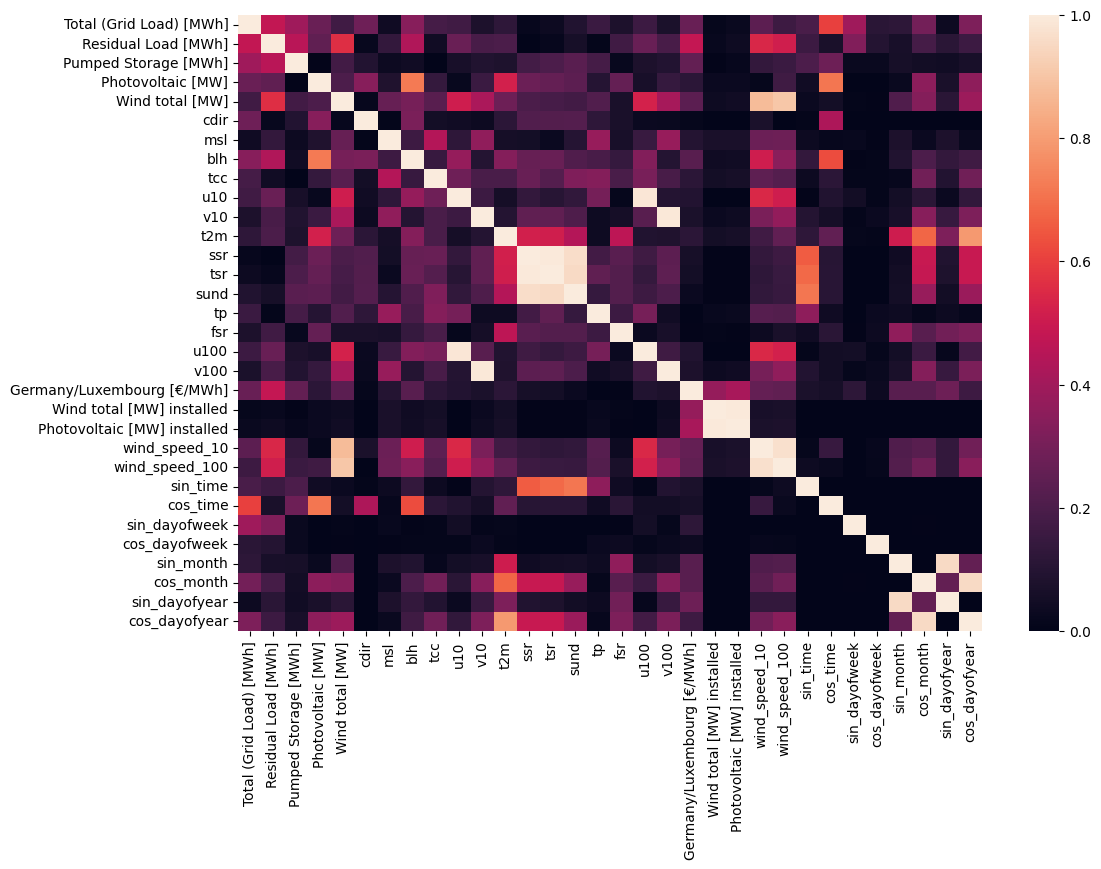

In [78]:
# plot absolute correlation matrix of all but last 8 columns
plt.figure(figsize=(12, 8))
sns.heatmap(min_max_data.corr().abs(), annot=False)
plt.show()

Text(0.5, 1.0, 'Correlation Matrix for Photovoltaic Supply')

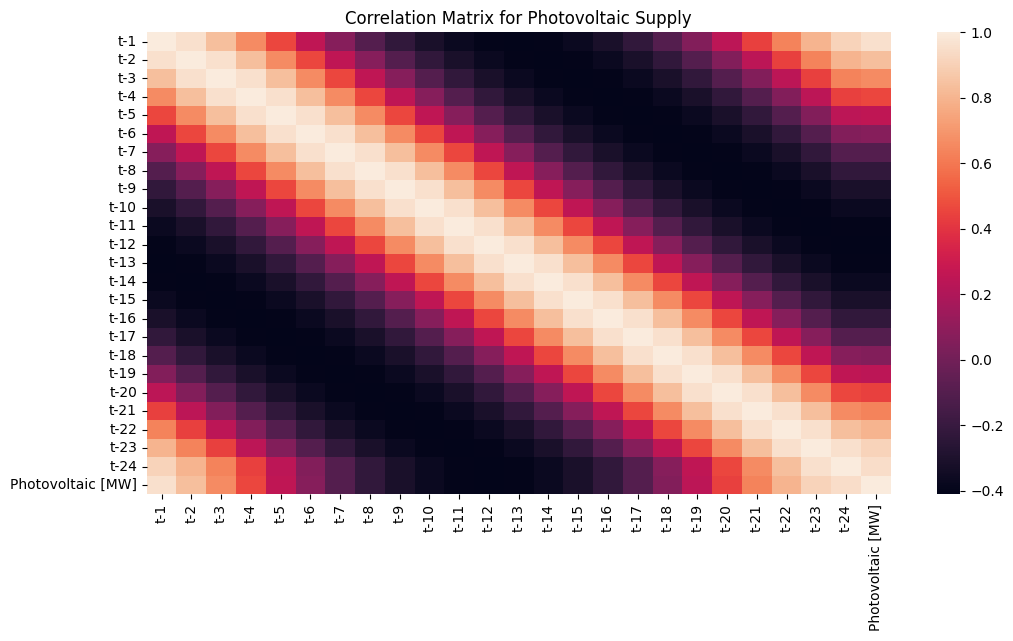

In [79]:
HISTORY = 24
photovoltaic_corr = pd.DataFrame()
for i in range(1, HISTORY+1):
    photovoltaic_corr[f't-{i}'] = min_max_data['Photovoltaic [MW]'].shift(i) 
photovoltaic_corr['Photovoltaic [MW]'] = min_max_data['Photovoltaic [MW]']   
photovoltaic_corr = photovoltaic_corr.dropna()
corr_matrix = photovoltaic_corr.corr()
#plot correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation Matrix for Photovoltaic Supply")

Text(0.5, 1.0, 'Correlation Matrix for total Wind Supply')

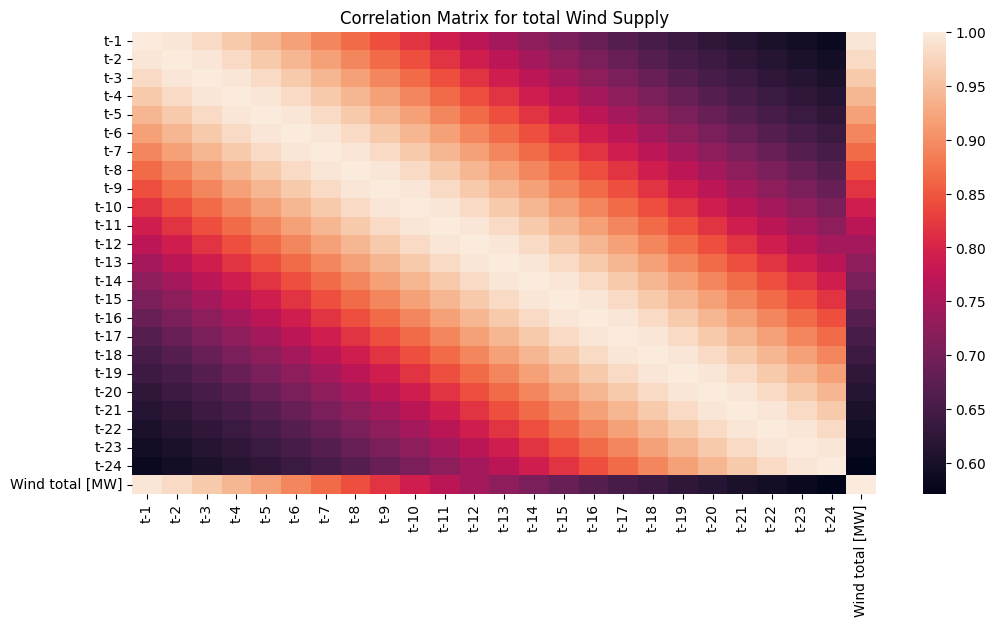

In [80]:
wind_corr = pd.DataFrame()
for i in range(1, HISTORY+1):
    wind_corr[f't-{i}'] = min_max_data['Wind total [MW]'].shift(i)
wind_corr['Wind total [MW]'] = min_max_data['Wind total [MW]']
wind_corr = wind_corr.dropna()
corr_matrix_wind = wind_corr.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix_wind, annot=False)
plt.title("Correlation Matrix for total Wind Supply")

In [81]:
pv_cols = correlation_pv.index[:10]
wind_cols = correlation_wind.index[:10]
pv_cols = pv_cols.append(dataset_train.columns[-8:])
wind_cols = wind_cols.append(dataset_train.columns[-8:])

print(pv_cols)
print(wind_cols)

Index(['Photovoltaic [MW]', 'blh', 't2m', 'cdir', 'ssr',
       'Total (Grid Load) [MWh]', 'fsr', 'tsr', 'Residual Load [MWh]', 'sund',
       'sin_time', 'cos_time', 'sin_dayofweek', 'cos_dayofweek', 'sin_month',
       'cos_month', 'sin_dayofyear', 'cos_dayofyear'],
      dtype='object')
Index(['Wind total [MW]', 'wind_speed_100', 'wind_speed_10',
       'Residual Load [MWh]', 'u100', 'u10', 'v10', 'v100', 'blh', 't2m',
       'sin_time', 'cos_time', 'sin_dayofweek', 'cos_dayofweek', 'sin_month',
       'cos_month', 'sin_dayofyear', 'cos_dayofyear'],
      dtype='object')


In [82]:
training_data_path = "data/training_data/"
if not os.path.exists(training_data_path):
    os.makedirs(training_data_path)

In [83]:
min_max_data[pv_cols].to_csv(training_data_path + "train_pv_new.csv", index=False)
min_max_data[wind_cols].to_csv(training_data_path + "train_wind_new.csv", index=False)
dataset_train[pv_cols].to_csv(training_data_path + "train_pv_unnorm.csv", index=False)
dataset_train[wind_cols].to_csv(training_data_path + "train_wind_unnorm.csv", index=False)

In [84]:
demand_data_hourly_test = demand_data_hourly.loc['2022']
supply_data_hourly_test = supply_data_hourly.loc['2022']
weather_test = pd.read_csv('data\weather\Weather_Data_Germany_2022.csv', delimiter=',')
average_weather_test =  weather_test.groupby('time').mean().reset_index()

average_weather_test.drop(columns=['longitude', 'latitude', 'z'], inplace=True)
average_weather_test.head()

,time,cdir,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,2022-01-01 00:00:00,0.0,102273.265638,521.390479,0.813598,4.358034,0.927748,281.935614,0.0,2.0,0.0,0.000000,0.743541,7.843346,1.139060
1,2022-01-01 01:00:00,0.0,102303.302163,518.044548,0.846501,4.240596,0.937809,281.851991,0.0,2.0,0.0,0.000053,0.743912,7.688815,1.100552
2,2022-01-01 02:00:00,0.0,102339.502387,502.108739,0.851758,4.038470,0.953366,281.675456,0.0,2.0,0.0,0.000097,0.743955,7.403461,1.147971
3,2022-01-01 03:00:00,0.0,102357.353887,487.356447,0.849956,3.950783,1.105889,281.483146,0.0,2.0,0.0,0.000119,0.743909,7.214726,1.376127
4,2022-01-01 04:00:00,0.0,102375.707938,468.625227,0.828486,3.794845,1.171168,281.301690,0.0,2.0,0.0,0.000136,0.743862,6.977483,1.536237


In [85]:
average_weather_test['time'] = pd.to_datetime(average_weather_test['time'])
average_weather_test.set_index('time', inplace=True)
test_data = pd.concat([demand_data_hourly_test, supply_data_hourly_test, average_weather_test], axis=1)


In [86]:
test_data['cdir'] = test_data['cdir'].diff().fillna(0)
test_data['wind_speed_10'] = np.sqrt(test_data['u10']**2 + test_data['v10']**2)
test_data['wind_speed_100'] = np.sqrt(test_data['u100']**2 + test_data['v100']**2)
test_data['hour'] = test_data.index.hour
test_data['dayofweek'] = test_data.index.dayofweek
test_data['month'] = test_data.index.month
test_data['dayofyear'] = test_data.index.dayofyear
test_data['sin_time'] = np.sin(2*np.pi*test_data['hour']/24)
test_data['cos_time'] = np.cos(2*np.pi*test_data['hour']/24)
test_data['sin_dayofweek'] = np.sin(2*np.pi*test_data['dayofweek']/7)
test_data['cos_dayofweek'] = np.cos(2*np.pi*test_data['dayofweek']/7)
test_data['sin_month'] = np.sin(2*np.pi*test_data['month']/12)
test_data['cos_month'] = np.cos(2*np.pi*test_data['month']/12)
test_data['sin_dayofyear'] = np.sin(2*np.pi*test_data['dayofyear']/365)
test_data['cos_dayofyear'] = np.cos(2*np.pi*test_data['dayofyear']/365)
test_data.drop(columns=['hour', 'dayofweek', 'month', 'dayofyear'], inplace=True)

In [87]:
test_data.head()

,Total (Grid Load) [MWh],Residual Load [MWh],Pumped Storage [MWh],Photovoltaic [MW],Wind total [MW],cdir,msl,blh,tcc,u10,...,wind_speed_10,wind_speed_100,sin_time,cos_time,sin_dayofweek,cos_dayofweek,sin_month,cos_month,sin_dayofyear,cos_dayofyear
2022-01-01 00:00:00,10978.8750,3113.0625,634.8125,0.0,7865.8125,0.0,102273.265638,521.390479,0.813598,4.358034,...,4.455690,7.925625,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 01:00:00,10383.9375,2870.0000,716.5625,0.0,7513.9375,0.0,102303.302163,518.044548,0.846501,4.240596,...,4.343057,7.767181,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 02:00:00,10120.1875,2954.6875,800.9375,0.0,7165.5000,0.0,102339.502387,502.108739,0.851758,4.038470,...,4.149476,7.491933,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 03:00:00,9891.0000,3045.7500,927.0000,0.0,6845.2500,0.0,102357.353887,487.356447,0.849956,3.950783,...,4.102643,7.344793,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 04:00:00,9834.5625,3314.1875,977.5000,0.0,6520.3750,0.0,102375.707938,468.625227,0.828486,3.794845,...,3.971459,7.144599,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852


In [88]:
def min_max_norm(x, min_val, max_val):
    return (x - min_val) * 2 / (max_val - min_val) - 1


In [96]:
#min max norma test data using min and max from training data
# get all max and min values from training data for each column
max_values = dataset_train.max()
min_values = dataset_train.min()
#save max and min values for each column
max_values.to_csv(training_data_path + "max_values.csv")
min_values.to_csv(training_data_path + "min_values.csv")

In [90]:
min_max_test = test_data.copy()
for col in test_data.columns[:-8]:
    min_max_test[col] = min_max_norm(test_data[col], min_values[col], max_values[col])

In [91]:
pv_test = min_max_test[pv_cols]
wind_test = min_max_test[wind_cols]
pv_unnorm = test_data[pv_cols]
wind_unnorm = test_data[wind_cols]
pv_test.head()

,Photovoltaic [MW],blh,t2m,cdir,ssr,Total (Grid Load) [MWh],fsr,tsr,Residual Load [MWh],sund,sin_time,cos_time,sin_dayofweek,cos_dayofweek,sin_month,cos_month,sin_dayofyear,cos_dayofyear
2022-01-01 00:00:00,-1.0,-0.495468,-0.099275,0.797313,-0.999999,-0.547441,0.727969,-0.999999,-0.724030,-0.999999,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 01:00:00,-1.0,-0.498944,-0.103210,0.797313,-0.999999,-0.646535,0.757969,-0.999999,-0.751126,-0.999999,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 02:00:00,-1.0,-0.515498,-0.111516,0.797313,-0.999999,-0.690466,0.761396,-0.999999,-0.741685,-0.999999,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 03:00:00,-1.0,-0.530822,-0.120564,0.797313,-0.999999,-0.728640,0.757745,-0.999999,-0.731534,-0.999999,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 04:00:00,-1.0,-0.550280,-0.129101,0.797313,-0.999999,-0.738040,0.753897,-0.999999,-0.701609,-0.999999,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852


In [92]:
wind_test.head()

,Wind total [MW],wind_speed_100,wind_speed_10,Residual Load [MWh],u100,u10,v10,v100,blh,t2m,sin_time,cos_time,sin_dayofweek,cos_dayofweek,sin_month,cos_month,sin_dayofyear,cos_dayofyear
2022-01-01 00:00:00,0.354091,0.010819,-0.091503,-0.724030,0.426393,0.346313,-0.015074,-0.073381,-0.495468,-0.099275,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 01:00:00,0.293266,-0.009505,-0.114502,-0.751126,0.413756,0.331873,-0.013675,-0.076837,-0.498944,-0.103210,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 02:00:00,0.233036,-0.044811,-0.154030,-0.741685,0.390419,0.307020,-0.011512,-0.072582,-0.515498,-0.111516,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 03:00:00,0.177677,-0.063684,-0.163593,-0.731534,0.374985,0.296238,0.009695,-0.052110,-0.530822,-0.120564,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852
2022-01-01 04:00:00,0.121520,-0.089363,-0.190379,-0.701609,0.355583,0.277064,0.018771,-0.037744,-0.550280,-0.129101,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025,0.017213,0.999852


In [93]:
test_data_path = "data/test_data/"  

if not os.path.exists(test_data_path):
    os.makedirs(test_data_path)

In [94]:
wind_test.to_csv(test_data_path + "test_wind_new.csv", index=False)
pv_test.to_csv(test_data_path + "test_pv_new.csv", index=False)
pv_unnorm.to_csv(test_data_path + "test_pv_unnorm.csv", index=False)
wind_unnorm.to_csv(test_data_path + "test_wind_unnorm.csv", index=False)

In [95]:
check = pd.read_csv(test_data_path + "test_wind_new.csv")